In [27]:
# here we take the data as it is and try a binary logistic regression with data from one person -> results are pretty good 80% accuracy on test set, then we tried on 3 different labels to see how the logistic regression holds up, probably not well
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

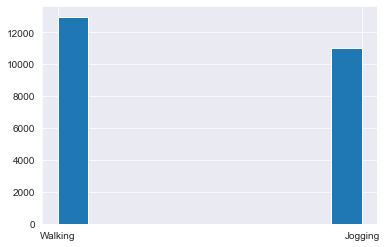

       user  activity        timestamp  x-axis  y-axis  z-axis
53503     3         1  100832351478000    2.87   18.81   -0.89
53504     3         1  100832391547000   -0.38    8.24   -1.27
53505     3         1  100832431556000    1.33    7.16   -1.95
53506     3         1  100832471839000    4.06    9.66   -1.84
53507     3         1  100832551551000    1.69    6.55   -0.11
[[ 3.00000000e+00  1.00000000e+00  1.00832351e+14  2.87000000e+00
   1.88100000e+01 -8.90000000e-01]
 [ 3.00000000e+00  1.00000000e+00  1.00832392e+14 -3.80000000e-01
   8.24000000e+00 -1.27000000e+00]
 [ 3.00000000e+00  1.00000000e+00  1.00832432e+14  1.33000000e+00
   7.16000000e+00 -1.95000000e+00]
 ...
 [ 3.00000000e+00  0.00000000e+00  1.02290261e+14  3.53000000e+00
   1.05700000e+01  1.80000000e+00]
 [ 3.00000000e+00  0.00000000e+00  1.02290341e+14  6.97000000e+00
   7.59000000e+00  9.50000000e-01]
 [ 3.00000000e+00  0.00000000e+00  1.02290381e+14  7.86000000e+00
   6.05000000e+00  9.50000000e-01]]
(23988, 3)

C:\Users\Florin Mazilu\AppData\Local\Temp\ipykernel_20556\1434642871.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['activity'] = new_df['activity'].map(activity_map)


In [28]:
df = pd.read_csv('time_series_data_human_activities.csv')
activity_map = {'Jogging': 0, 'Walking': 1}

# select only one person and two activities i.e. Standing and walking
new_df = df[(df['user']==3) & ((df['activity']=='Jogging') | (df['activity']=='Walking'))]
new_df['activity'].hist()
plt.show()
# one-hot encoding
# one_hot = pd.get_dummies(new_df['activity'])
# new_df = new_df.drop('activity', axis=1)
# new_df = pd.concat([new_df, one_hot], axis=1)

new_df['activity'] = new_df['activity'].map(activity_map)

print(new_df.head())

values = new_df.to_numpy()
print(values)

X = values[:, -3:]
y = values[:, 1].astype("int")
print(X.shape, y.shape)

In [29]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [30]:
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 16791
num test: 7197


In [31]:
# logistic regression model
def model(X, obs=None):
    alpha = pyro.sample('alpha', pyro.distributions.Normal(0., 1.))
    beta = pyro.sample('beta', pyro.distributions.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1])).to_event(1))
    with pyro.plate('data'):
        y = pyro.sample("y", pyro.distributions.Bernoulli(probs=torch.sigmoid(alpha + beta.T@X.T)), obs=obs)
    return y

In [32]:
n_cat = 2
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
print(y_train.shape)

torch.Size([16791])


In [33]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 30000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 12022.0
[1000] ELBO: 8595.1
[2000] ELBO: 8517.6
[3000] ELBO: 8514.0
[4000] ELBO: 8514.2
[5000] ELBO: 8515.7
[6000] ELBO: 8514.8
[7000] ELBO: 8515.7
[8000] ELBO: 8515.2
[9000] ELBO: 8515.0
[10000] ELBO: 8515.3
[11000] ELBO: 8515.3
[12000] ELBO: 8515.1
[13000] ELBO: 8515.0
[14000] ELBO: 8515.3
[15000] ELBO: 8514.9
[16000] ELBO: 8515.1
[17000] ELBO: 8514.9
[18000] ELBO: 8515.1
[19000] ELBO: 8515.3
[20000] ELBO: 8515.1
[21000] ELBO: 8515.0
[22000] ELBO: 8514.9
[23000] ELBO: 8515.3
[24000] ELBO: 8515.7
[25000] ELBO: 8515.8
[26000] ELBO: 8514.8
[27000] ELBO: 8515.0
[28000] ELBO: 8514.8
[29000] ELBO: 8515.2


In [34]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, y_train)

In [35]:
alpha_hat = samples["alpha"].detach().mean(axis=0).numpy()
beta_hat = samples["beta"].detach().squeeze().mean(axis=0).numpy()

# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = (y_hat > 0).astype(int)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

# Results are pretty good, but the activities are quite different, if we had jogging and walking the results would not have been this good. Sitting and walking: 99% acc, Jogging and walking: 75.1% acc

Accuracy: 0.7500347366958455


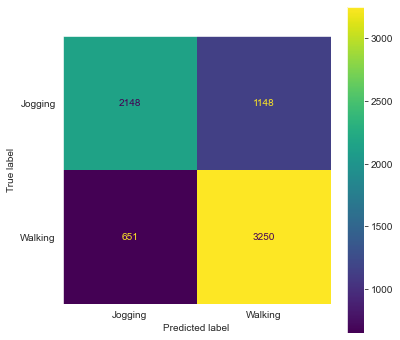

In [36]:
#this section plots confusion matrix and prints testing accuracy
fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
ls = ['Jogging', 'Walking']
cm = confusion_matrix(y_test, y_hat, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=ls).plot(ax=ax)
# disp = disp.plot(cmap=plt.cm.Blues)
# plt.show()